## Intro

When Librosa loads an audio file, there is a default sample rate, which is the number of samples from the mp3's audio signal for one second. Therefore,
to get the length of a song in real time we take the length of the read-in array and divide by the sample rate for that audio sample.

In [64]:
# system packages
import os
import warnings
import timeit

# data stuff
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

## sklearn stuff
from sklearn.preprocessing import LabelEncoder

## Audio Stuff
import librosa
import librosa.display
import torchaudio

warnings.filterwarnings("ignore", category=UserWarning)

In [65]:
audio_dir = './data/fma_small/'

The next code chunk is Super handy function that just searches for every mp3 file within the audio directory. 
My audio folder has a bunch of subfolders like '000', '099', etc, and the audio files are
one level further down.

In [66]:
filepaths = librosa.util.files.find_files(audio_dir)

Here is what a typical load looks like. Specifying `sr=None` ensures that the file's default sample-rate is preserved. 
We can also specify the duration with `librosa.load`.

In [67]:
example_source, sr = librosa.load(filepaths[0], sr=None, duration=0.5)
librosa.get_duration(example_source, sr=sr)

0.5

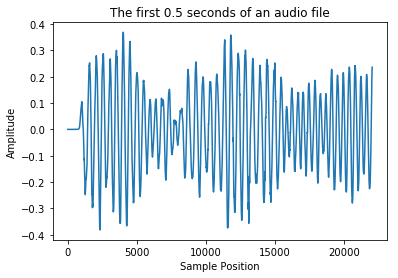

In [40]:
plt.plot(example_source)
plt.title(f"The first {librosa.get_duration(example_source, sr=sr)} seconds of an audio file")
plt.xlabel("Sample Position")
plt.ylabel("Amplitude")
plt.show()

In [61]:
def view_melspec(source, sr):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(source, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=4096)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

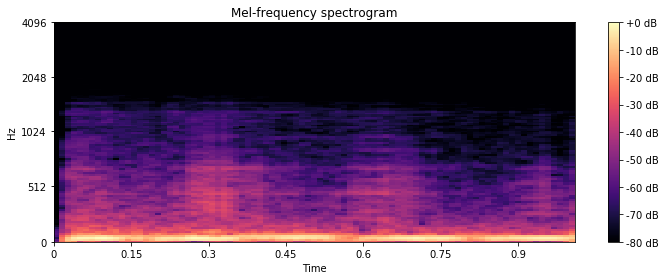

In [62]:
view_melspec(example_source, sr)

## How long does a typical load take?

In [41]:
duration = 1 # second

In [42]:
%%timeit

librosa.load(filepaths[0], sr=None, duration = duration)
# librosa.get_samplerate(filepaths[0])

19.7 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


On my linux virtual machine, one second of audio takes between 143 and 214 milliseconds to load one second of audio (down to 129 ms if we don't force a sample rate). 
Multiplying this number by 8 is about how long it will take to load the entire dataset in. I estimate about 15 minutes for the whole FMA Small dataset.

However, on my macbook it takes about 16 ms to load one second of audio in. For five seconds of audio, about 34 ms. This is much faster than the ubuntu machine! This means an estimated 134 seconds, or about two minutes.

In [43]:
%%timeit 

torchaudio.info(filepaths[0])

314 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This runs a lot faster at 270 microseconds on my ubuntu virtual machine, so it will be a better tool to 
check for integrity. On the macbook it takes about 330 microseconds, a bit slower.


## Check for integrity

This is the only point where I will use `torchaudio` for the `torchaudio.info` method. This method
tries to open the file without loading it into memory. This allows us to check
for corrupted mp3 files. 

In [88]:
bad_files = []
for file in filepaths:
    try:
        torchaudio.info(file)
    except RuntimeError:
        bad_files.append(file)
bad_files

['/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/099/099134.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/108/108925.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/133/133297.mp3']

## Estimating memory cost

In [45]:
# Find out how much one second costs in memory
example_source, sr = librosa.load(filepaths[0], sr=None, duration=1)

# Estimate for all songs
print(f"{(example_source.nbytes/10**9) * 8000} GB of memory for all 8000 songs") # gigabytes

1.4112 GB of memory for all 8000 songs


## Managing Metadata 

The following code takes the giant metadata file coming with the FMA datasets and selects
the track ids and the genres.

In [46]:
metadata_file = os.path.join('data','fma_metadata', 'tracks.csv')

all_metadata = pd.read_csv(metadata_file, header=[0,1], index_col=0)

cols_to_keep = [('track', 'genre_top')]

reduced_meta = all_metadata.loc[
            all_metadata[('set', 'subset')] == 'small',
            cols_to_keep
]

reduced_meta.reset_index(inplace=True)
reduced_meta.columns = ['track_id', 'genre']

In [47]:
# Encode the genres as integers 0 through 7.
enc = LabelEncoder()
reduced_meta['genre_enc'] = enc.fit_transform(reduced_meta['genre'].to_numpy().reshape(-1,1))

In [72]:
reduced_meta['path'] = filepaths

In [85]:
## check to make sure each path points to the right file
reduced_meta['track_id'].equals(
    reduced_meta['path'].apply(lambda x: int(os.path.split(x)[1][:-4]))
)

True

In [111]:
# Remove bad mp3s from the dataframe so that we skip them.
if reduced_meta.path.isin(bad_files).sum():
    reduced_meta.drop(
        reduced_meta.loc[reduced_meta.path.isin(bad_files), :].index,
        inplace=True
    )
    print(f"Dropped {len(bad_files)} rows from the dataframe.")

## Batch Generator

Since the data takes a lot of memory I will use a custom generator that loads batches as needed from the hard disk.

In [49]:
class Batch_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, music_filepaths, labels, batch_size) :
        self.music_filepaths = music_filepaths
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self) :
        """
        Return number of batches.
        """
        return (np.ceil(len(self.music_filepaths) / float(self.batch_size))).astype(np.int)
  
     def __getitem__(self, idx):
        
        batch_x = self.music_filepaths[idx * self.batch_size : (idx + 1) * self.batch_size]
#         batch_y = self.
        
#         batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
#         batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
#         return np.array([
#             resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
#                for file_name in batch_x])/255.0, np.array(batch_y)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 14)

In [ ]:
training_gen = Batch_Generator(filepaths[:10], labels = reduced_meta['genre_enc'].to_list()[:10], batch_size=2)

In [ ]:
len(training_gen)